In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
from matplotlib import gridspec
from scipy import stats
from sklearn import preprocessing
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# restart kernel
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [3]:
datafile="/data0/users/bpnachman/Gaia/GD1-circle-140-30-15.pkl"
gaiadata=np.load(datafile,allow_pickle=True)
gaiadata2=np.array(gaiadata[['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata2 = np.vstack([gaiadata2[:,0].T,
           gaiadata2[:,1].T,
           gaiadata2[:,2].T,
           gaiadata2[:,3].T,
           (gaiadata2[:,5]-gaiadata2[:,6]).T,
           gaiadata2[:,4].T, 
            gaiadata2[:,7].T]).T
gaiadata2 = gaiadata2[np.sum(np.isnan(gaiadata2),axis=1)==0]
center_dec=0.5*(np.max(gaiadata2[:,2])+np.min(gaiadata2[:,2]))
center_ra=0.5*(np.max(gaiadata2[:,3])+np.min(gaiadata2[:,3]))
radius=np.sqrt((gaiadata2[:,2]-center_dec)**2+(gaiadata2[:,3]-center_ra)**2)
gaiadata2=gaiadata2[radius<15]
np.random.shuffle(gaiadata2)

In [4]:
gaiadata3=np.array(gaiadata[gaiadata['streammask']==1][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata3 = np.vstack([gaiadata3[:,0].T,
           gaiadata3[:,1].T,
           gaiadata3[:,2].T,
           gaiadata3[:,3].T,
           (gaiadata3[:,5]-gaiadata3[:,6]).T,
           gaiadata3[:,4].T, 
           gaiadata3[:, 7].T]).T
gaiadata3 = gaiadata3[np.sum(np.isnan(gaiadata3),axis=1)==0]
radius=np.sqrt((gaiadata3[:,2]-center_dec)**2+(gaiadata3[:,3]-center_ra)**2)
gaiadata3=gaiadata3[radius<15]
np.random.shuffle(gaiadata3)

In [5]:
gaiadata2_no_gd1 = np.array(gaiadata[gaiadata['streammask']==0][['pmdec','pmra','dec','ra','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag', 'streammask']].astype('float32'))
gaiadata2_no_gd1 = np.vstack([gaiadata2_no_gd1[:,0].T,
           gaiadata2_no_gd1[:,1].T,
           gaiadata2_no_gd1[:,2].T,
           gaiadata2_no_gd1[:,3].T,
           (gaiadata2_no_gd1[:,5]-gaiadata2_no_gd1[:,6]).T,
           gaiadata2_no_gd1[:,4].T, 
            gaiadata2_no_gd1[:, 7].T]).T
gaiadata2_no_gd1 = gaiadata2_no_gd1[np.sum(np.isnan(gaiadata2_no_gd1),axis=1)==0]
radius=np.sqrt((gaiadata2_no_gd1[:,2]-center_dec)**2+(gaiadata2_no_gd1[:,3]-center_ra)**2)
gaiadata2_no_gd1=gaiadata2_no_gd1[radius<15]
np.random.shuffle(gaiadata2_no_gd1)                            

In [7]:
gaiadata.keys()

Index(['source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'phot_g_mean_mag', 'phot_bp_mean_mag',
       'phot_rp_mean_mag', 'bp_rp', 'radial_velocity', 'radial_velocity_error',
       'teff_val', 'streammask'],
      dtype='object')

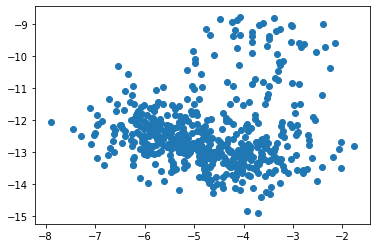

In [8]:
plt.scatter(gaiadata3[:,1],gaiadata3[:,0])

Text(0, 0.5, '$\\mu_\\delta$ [$\\mu$as/year]')

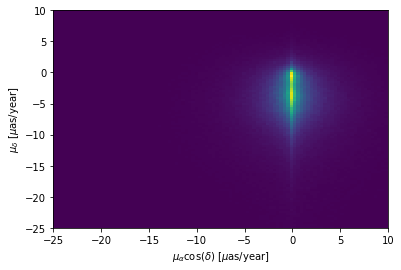

In [9]:
_,_,_,_=plt.hist2d(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),gaiadata2[:,0],bins=[np.linspace(-25,10,100),np.linspace(-25,10,100)])
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")
plt.ylabel(r"$\mu_\delta$ [$\mu$as/year]")

Text(0, 0.5, '$\\delta$ [degrees]')

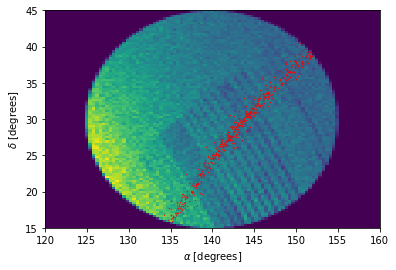

In [10]:
_,_,_,_=plt.hist2d(gaiadata2[:,3],gaiadata2[:,2],bins=[np.linspace(120,160,100),np.linspace(15,45,100)])
plt.scatter(gaiadata3[:,3],gaiadata3[:,2],color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0, 0.5, '$\\delta$ [degrees]')

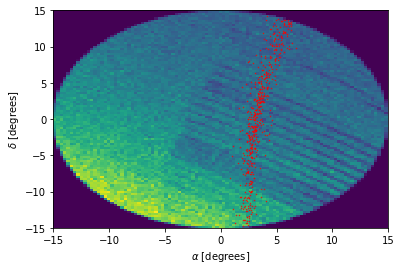

In [11]:
X = gaiadata2[:,3]-center_ra
Y = gaiadata2[:,2]-center_dec

Xs = gaiadata3[:,3]-center_ra
Ys = gaiadata3[:,2]-center_dec

theta = -0.5
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)
Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

_,_,_,_=plt.hist2d(Xr,Yr,bins=[np.linspace(-15,15,100),np.linspace(-15,15,100)])
plt.scatter(Xsr,Ysr,color='red',s=0.2)
plt.xlabel(r"$\alpha$ [degrees]")
plt.ylabel(r"$\delta$ [degrees]")

Text(0.5, 0, 'Rotated $\\delta$-$\\alpha$ space')

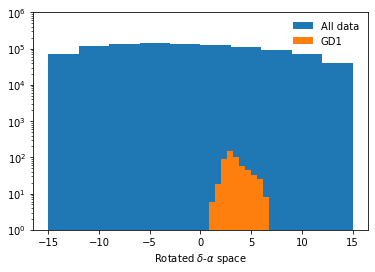

In [12]:
plt.hist(Xr,label="All data")
plt.hist(Xsr,label="GD1")
plt.yscale("log")
plt.legend(frameon=False)
plt.ylim([1,1e6])
plt.xlabel(r"Rotated $\delta$-$\alpha$ space")

Text(0.5, 0, '$\\mu_\\alpha\\cos(\\delta)$ [$\\mu$as/year]')

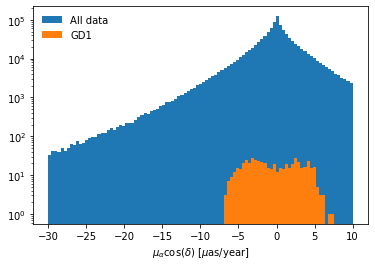

In [13]:
_,_,_=plt.hist(gaiadata2[:,1]*np.cos(gaiadata2[:,2]),bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,1]*np.cos(gaiadata3[:,2]),bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\alpha\cos(\delta)$ [$\mu$as/year]")

Text(0.5, 0, '$\\mu_\\delta$ [$\\mu$as/year]')

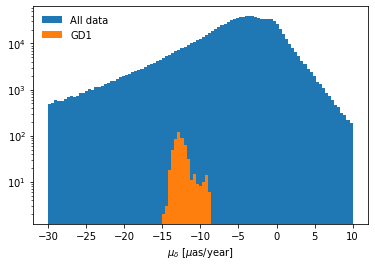

In [14]:
_,_,_=plt.hist(gaiadata2[:,0],bins=np.linspace(-30,10,100),label="All data")
_,_,_=plt.hist(gaiadata3[:,0],bins=np.linspace(-30,10,100),label="GD1")
plt.legend(frameon=False)
plt.yscale("log")
plt.xlabel(r"$\mu_\delta$ [$\mu$as/year]")

In [13]:
def build_data_arrays(SR, SB, GD1):
    X = SR[:,3]-center_ra
    Y = SR[:,2]-center_dec

    Xb = SB[:,3]-center_ra
    Yb = SB[:,2]-center_dec

    Xs = GD1[:,3]-center_ra
    Ys = GD1[:,2]-center_dec

    SR = np.c_[SR[:,0],SR[:,1],X, Y, SR[:,4],SR[:,5], SR[:,6]]
    SB = np.c_[SB[:,0],SB[:,1],Xb, Yb, SB[:,4],SB[:,5], SB[:,6]]
    GD1 = np.c_[GD1[:,0],GD1[:,1],Xs, Ys, GD1[:,4],GD1[:,5], GD1[:,6]]
    
    return SR, SB, GD1

In [36]:
def build_model(SR, SB, stream, num_models, all_data, plot_cuts = False):
    X = np.concatenate([SR,SB,stream])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(stream))])

    myscalar = preprocessing.StandardScaler().fit(X[:,:6])
    X_scaled = myscalar.transform(X[:,:6])
#     X_scaled = preprocessing.scale(X[:, :6])
    myscalar_all_data =  preprocessing.StandardScaler().fit(all_data[:,:6])
    all_data_scaled = myscalar_all_data.transform(all_data[:, :6])
    all_data_scaled = np.c_[all_data_scaled, all_data[:, 6]]
#     all_data_scaled = preprocessing.scale(all_data[:, :6])
#     all_data_scaled = np.c_[all_data_scaled, all_data[:, 6]]
    X_scaled = np.c_[X_scaled, X[:, 6]]
    stream_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    
#     plt.figure(figsize = (6, 6))
#     plt.hist(stream_scaled[:, 0],label = 'stream scaled', color = 'orange', bins = np.linspace(-30, 10, 100))
#     plt.show()
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

#     tpr_arr = []
#     fpr_arr = []
#     stream_background_x_arr = []
#     stream_background_y_arr = []

    for i in range(num_models):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:6],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:6],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
        preds_SR = preds[(Y_test == 1) * (X_test[:, 6] == 0)]
        
        preds_all = model.predict(all_data_scaled[:, 1:6], batch_size = int(0.1*len(all_data_scaled))) #0.01

        preds_stream = model.predict(stream_scaled[:,1:6], batch_size=int(0.1*len(stream_scaled)))

#         fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_stream))]), np.concatenate([preds_SR,preds_stream]))
#         fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
                
#         tpr_arr.append(tpr)
#         fpr_arr.append(fpr)
#         stream_background_x_arr.append(tpr2)
#         stream_background_y_arr.append(fpr2)
        
#         chi_squared_arr = []
        cuts = [0.,0.5,0.9,0.99, 0.999]
        bins_cuts = np.zeros((len(cuts), 99))
        stream_to_plot = []
#         prev_bins_sizes = []
        if plot_cuts:
            for i in range(len(cuts)):
                cut = cuts[i]
#                 X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#                 print(np.quantile(preds[Y_test==1], [cut]))
#                 print(preds_stream[:,0] > np.quantile(preds_all[Y_test==1],[cut])[0])
#                 print(stream_scaled[preds_stream[:,0] > np.quantile(preds_all[Y_test==1],[cut])[0]])

                #unscale here
                    
        #xaxis - pmdec
        #title with region


                X_unscaled = np.c_[myscalar.inverse_transform(X_scaled[:, :6]), X_scaled[:, 6]]

                stream_unscaled = np.c_[myscalar.inverse_transform(stream_scaled[:, :6]), stream_scaled[:, 6]]
                
                all_data_unscaled = np.c_[myscalar_all_data.inverse_transform(all_data_scaled[:, :6]), all_data_scaled[:, 6]]

#                 X_pass_stream = stream_scaled[preds_stream[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
                X_pass_stream = stream_unscaled[preds_stream[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
                if i == 0:
                    stream_to_plot = X_pass_stream
            
#                 X_pass_all = all_data_scaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
                X_pass_all = all_data_unscaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
                bins_cuts[i], _, _ = plt.hist(X_pass_all[:,0], bins = np.linspace(-30, 10, 100))
                plt.clf()
                
#                 plt.hist(X_pass_all[:,0], label = "All data", bins = np.linspace(-20, 10, 100))
#                 plt.hist(X_pass_stream[:,0], label = "GD1", bins = np.linspace(-20, 10, 100))
#                 plt.yscale("log")
#                 plt.show()
#                 plt.figure(figsize=(6,6))
#                 bin_sizes, _, _ = plt.hist(X_pass[:,1], label = "All data", alpha = 0.5, bins = np.linspace(-2, 2, 20))
# #                 print(bin_sizes)
                
#                 if i > 0:
#                     chi_squared_arr.append(sum([((b - p)**2)/p for b, p in zip(bin_sizes, prev_bin_sizes)]))

#                 #plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
#                 plt.hist(X_pass_stream[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
#                 plt.yscale("log")
#                 plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
#                 plt.ylim([1,1e6])
#                 plt.ylabel("Counts",fontsize=20)
#                 plt.xlabel("Proper motion RA",fontsize=20)
#                 plt.show()
#                 if i == 0:
#                     prev_bin_sizes = bin_sizes

            return stream_to_plot, bins_cuts
    
#     return tpr_arr, fpr_arr, chi_squared_arr

In [6]:
def index_to_xcoord(j):
    return -30 + 40*j/100

In [7]:
threshold_arr_size = 10000

In [ ]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]

if len(SR) >= threshold_arr_size:
    SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
    _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
    _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
    plt.legend(frameon=False)
    plt.show()
    build_model(SR, SB, GD1, 1, gaiadata2, True)

In [ ]:
SR = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -15)*(gaiadata2_no_gd1[:,0] < -11)]
SB = gaiadata2_no_gd1[(gaiadata2_no_gd1[:,0] > -18)*(gaiadata2_no_gd1[:,0] < -15)+(gaiadata2_no_gd1[:,0] > -11)*(gaiadata2_no_gd1[:,0] < -9.5)]

if len(SR) >= threshold_arr_size:
    SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
    _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
    _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
    plt.legend(frameon=False)
    plt.show()
    build_model(SR, SB, GD1, 1, gaiadata2, True)

In [11]:
def calc_diff(SR, SB):
    return abs(len(SR) - len(SB))

In [10]:
def find_SR_SB_pointers(pointers, increment, data_arr):
    SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
    SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]

    previous_diff = calc_diff(SR, SB)
    prev_SR, prev_SB = SR, SB
    curr_diff = previous_diff
    bottom_bool = False
    top_bool = True

    while curr_diff <= previous_diff and pointers[3] < end_point:
        previous_diff, prev_SR, prev_SB = curr_diff, SR, SB
        if bottom_bool:
            pointers[0] = max(start_point, pointers[0] - increment)
        else:
            pointers[3] = min(end_point, pointers[3] + increment)
        bottom_bool, top_bool = top_bool, bottom_bool
        SR = data_arr[(data_arr[:,0] > pointers[1])*(data_arr[:,0] < pointers[2])]
        SB = data_arr[(data_arr[:,0] > pointers[0])*(data_arr[:,0] < pointers[1]) + (data_arr[:,0] > pointers[2])*(data_arr[:,0] < pointers[3])]
        curr_diff = calc_diff(SR, SB)

    return prev_SR, prev_SB

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

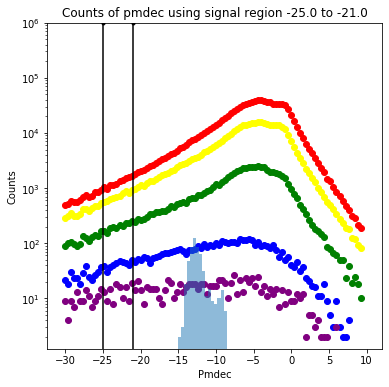

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

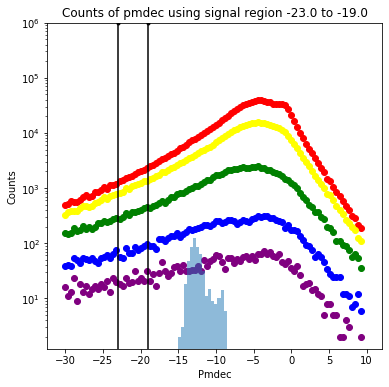

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

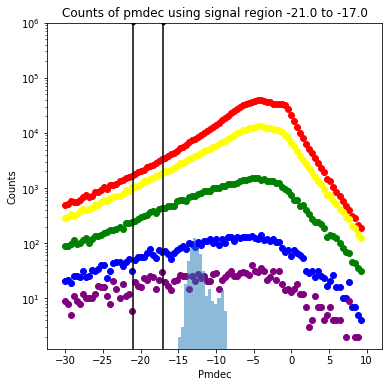

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

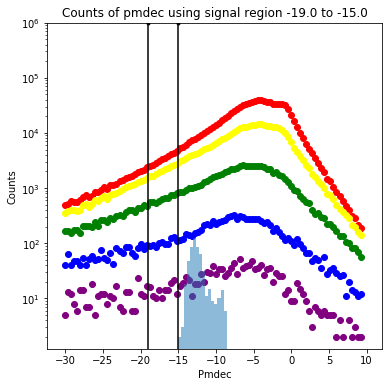

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

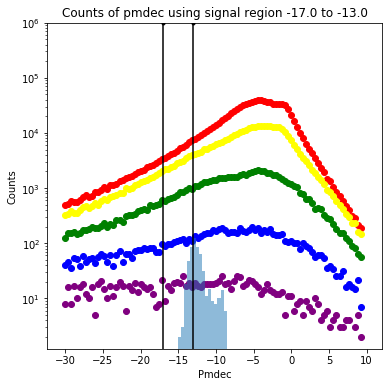

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

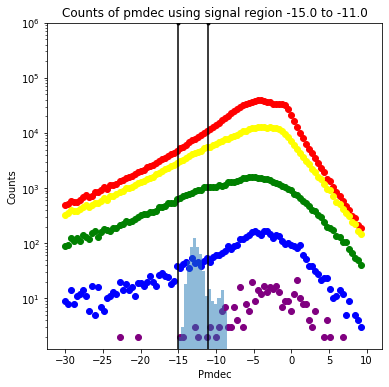

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

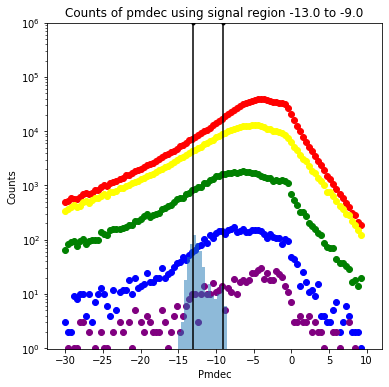

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

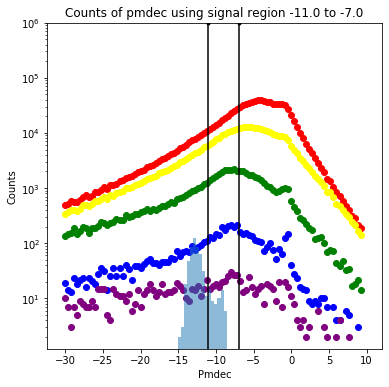

In [40]:
start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
colors = ['red', 'yellow', 'green', 'blue', 'purple']

#where the turnaround occurs
end_point = -5

while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2)
    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
        X_pass_stream, bins_cuts = build_model(SR, SB, GD1, 1, gaiadata2, True)
        plt.figure(figsize = (6, 6))
        plt.hist(X_pass_stream[:,0], alpha = 0.5, label = "GD1", bins = np.linspace(-30, 10, 100))
        for i in range(len(bins_cuts)):
            curr_color = colors[i]
            for j in range(len(bins_cuts[0])):
                plt.scatter(index_to_xcoord(j), bins_cuts[i][j], color = curr_color)
        plt.yscale('log')
        plt.ylim([0, 10e5])
        plt.xlabel('Pmdec')
        plt.ylabel('Counts')
        plt.plot([pointers[1], pointers[1]], [0, 10e5], marker = '.', color = 'black')
        plt.plot([pointers[2], pointers[2]], [0, 10e5], marker = '.', color = 'black')
        title_str = 'Counts of pmdec using signal region ' + str(round(pointers[1])) + ' to ' + str(round(pointers[2]))
        plt.title(title_str)
        plt.show()   
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

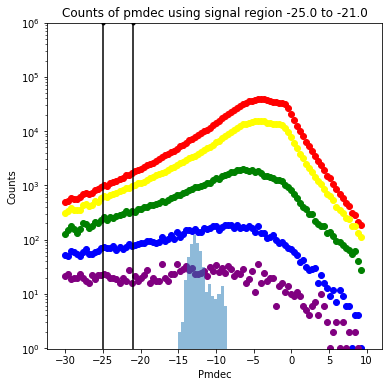

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

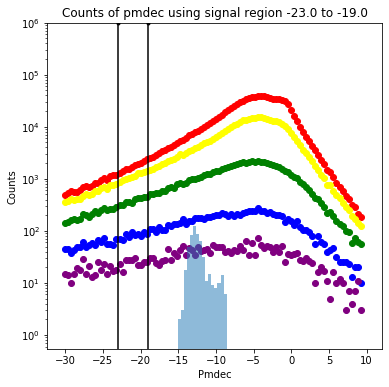

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

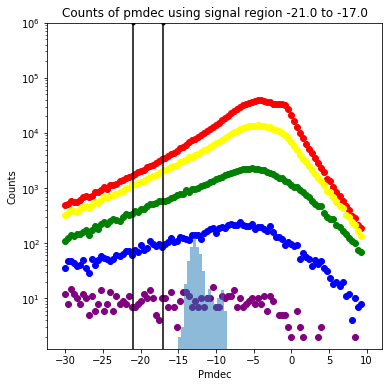

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

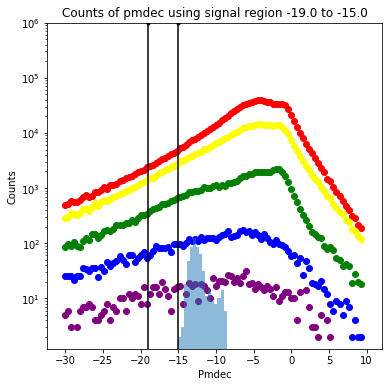

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

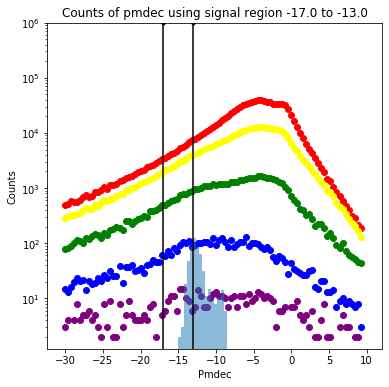

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

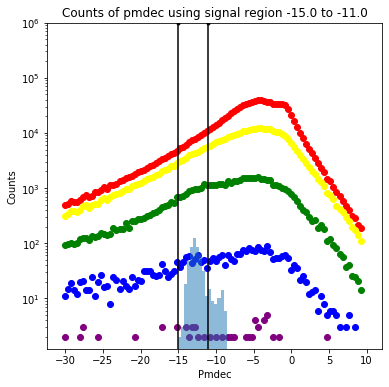

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

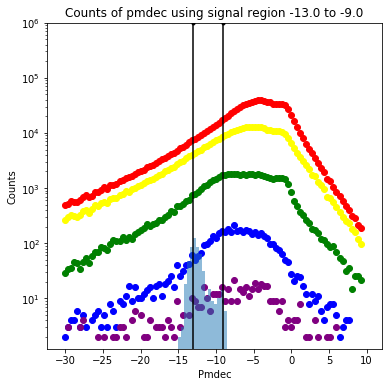

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:143: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

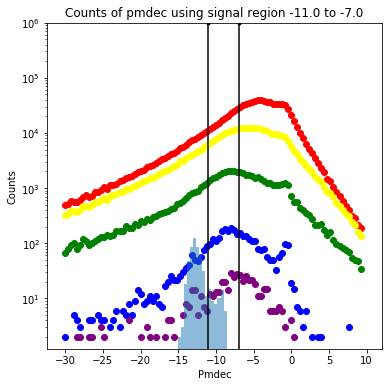

In [41]:
def build_model_diff_arch(SR, SB, stream, num_models, all_data, plot_cuts = False):
    X = np.concatenate([SR,SB,stream])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(stream))])

    myscalar = preprocessing.StandardScaler().fit(X[:,:6])
    X_scaled = myscalar.transform(X[:,:6])
#     X_scaled = preprocessing.scale(X[:, :6])


    #no my_sclar_all_data
    myscalar_all_data =  preprocessing.StandardScaler().fit(all_data[:,:6])
    all_data_scaled = myscalar_all_data.transform(all_data[:, :6])
    all_data_scaled = np.c_[all_data_scaled, all_data[:, 6]]
#     all_data_scaled = preprocessing.scale(all_data[:, :6])
#     all_data_scaled = np.c_[all_data_scaled, all_data[:, 6]]
    X_scaled = np.c_[X_scaled, X[:, 6]]
    stream_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]
    
#     plt.figure(figsize = (6, 6))
#     plt.hist(stream_scaled[:, 0],label = 'stream scaled', color = 'orange', bins = np.linspace(-30, 10, 100))
#     plt.show()
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)

#     tpr_arr = []
#     fpr_arr = []
#     stream_background_x_arr = []
#     stream_background_y_arr = []

    for i in range(num_models):

        model = Sequential()
        model.add(Dense(256, input_dim=5, activation='relu', bias_initializer='glorot_normal')) 
        model.add(Dense(256, activation='relu'))
        model.add(Dense(256, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:6],Y_train, epochs=30, batch_size=200,validation_data=(X_test[:,1:6],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
        preds_SR = preds[(Y_test == 1) * (X_test[:, 6] == 0)]
        
        preds_all = model.predict(all_data_scaled[:, 1:6], batch_size = int(0.1*len(all_data_scaled))) #0.01

        preds_stream = model.predict(stream_scaled[:,1:6], batch_size=int(0.1*len(stream_scaled)))

#         fpr, tpr, thresholds = roc_curve(np.concatenate([np.zeros(len(preds_SR)),np.ones(len(preds_stream))]), np.concatenate([preds_SR,preds_stream]))
#         fpr2, tpr2, thresholds2 = roc_curve(Y_test, preds)
                
#         tpr_arr.append(tpr)
#         fpr_arr.append(fpr)
#         stream_background_x_arr.append(tpr2)
#         stream_background_y_arr.append(fpr2)
        
#         chi_squared_arr = []
        cuts = [0.,0.5,0.9,0.99, 0.999]
        bins_cuts = np.zeros((len(cuts), 99))
        stream_to_plot = []
#         prev_bins_sizes = []
        if plot_cuts:
            for i in range(len(cuts)):
                cut = cuts[i]
#                 X_pass = X_test[(Y_test==1)*(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
#                 print(np.quantile(preds[Y_test==1], [cut]))
#                 print(preds_stream[:,0] > np.quantile(preds_all[Y_test==1],[cut])[0])
#                 print(stream_scaled[preds_stream[:,0] > np.quantile(preds_all[Y_test==1],[cut])[0]])

                #unscale here
                    
        #xaxis - pmdec
        #title with region


                X_unscaled = np.c_[myscalar.inverse_transform(X_scaled[:, :6]), X_scaled[:, 6]]

                stream_unscaled = np.c_[myscalar.inverse_transform(stream_scaled[:, :6]), stream_scaled[:, 6]]
                
                all_data_unscaled = np.c_[myscalar_all_data.inverse_transform(all_data_scaled[:, :6]), all_data_scaled[:, 6]]

#                 X_pass_stream = stream_scaled[preds_stream[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
                X_pass_stream = stream_unscaled[preds_stream[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
                if i == 0:
                    stream_to_plot = X_pass_stream
            
#                 X_pass_all = all_data_scaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
                X_pass_all = all_data_unscaled[(preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
                bins_cuts[i], _, _ = plt.hist(X_pass_all[:,0], bins = np.linspace(-30, 10, 100))
                plt.clf()
                
#                 plt.hist(X_pass_all[:,0], label = "All data", bins = np.linspace(-20, 10, 100))
#                 plt.hist(X_pass_stream[:,0], label = "GD1", bins = np.linspace(-20, 10, 100))
#                 plt.yscale("log")
#                 plt.show()
#                 plt.figure(figsize=(6,6))
#                 bin_sizes, _, _ = plt.hist(X_pass[:,1], label = "All data", alpha = 0.5, bins = np.linspace(-2, 2, 20))
# #                 print(bin_sizes)
                
#                 if i > 0:
#                     chi_squared_arr.append(sum([((b - p)**2)/p for b, p in zip(bin_sizes, prev_bin_sizes)]))

#                 #plt.hist(X_pass[:,1],label="All data",alpha=0.5,bins=np.linspace(-2,2,20))
#                 plt.hist(X_pass_stream[:,1],label="GD1",alpha=0.5,bins=np.linspace(-2,2,20))
#                 plt.yscale("log")
#                 plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
#                 plt.ylim([1,1e6])
#                 plt.ylabel("Counts",fontsize=20)
#                 plt.xlabel("Proper motion RA",fontsize=20)
#                 plt.show()
#                 if i == 0:
#                     prev_bin_sizes = bin_sizes

            return stream_to_plot, bins_cuts
    
#     return tpr_arr, fpr_arr, chi_squared_arr


start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
colors = ['red', 'yellow', 'green', 'blue', 'purple']

#where the turnaround occurs
end_point = -5

while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2)
    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
        X_pass_stream, bins_cuts = build_model_diff_arch(SR, SB, GD1, 1, gaiadata2, True)
        plt.figure(figsize = (6, 6))
        plt.hist(X_pass_stream[:,0], alpha = 0.5, label = "GD1", bins = np.linspace(-30, 10, 100))
        for i in range(len(bins_cuts)):
            curr_color = colors[i]
            for j in range(len(bins_cuts[0])):
                plt.scatter(index_to_xcoord(j), bins_cuts[i][j], color = curr_color)
        plt.yscale('log')
        plt.ylim([0, 10e5])
        plt.xlabel('Pmdec')
        plt.ylabel('Counts')
        plt.plot([pointers[1], pointers[1]], [0, 10e5], marker = '.', color = 'black')
        plt.plot([pointers[2], pointers[2]], [0, 10e5], marker = '.', color = 'black')
        title_str = 'Counts of pmdec using signal region ' + str(round(pointers[1])) + ' to ' + str(round(pointers[2]))
        plt.title(title_str)
        plt.show()   
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

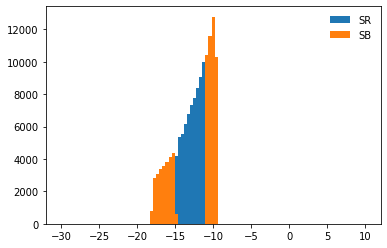

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

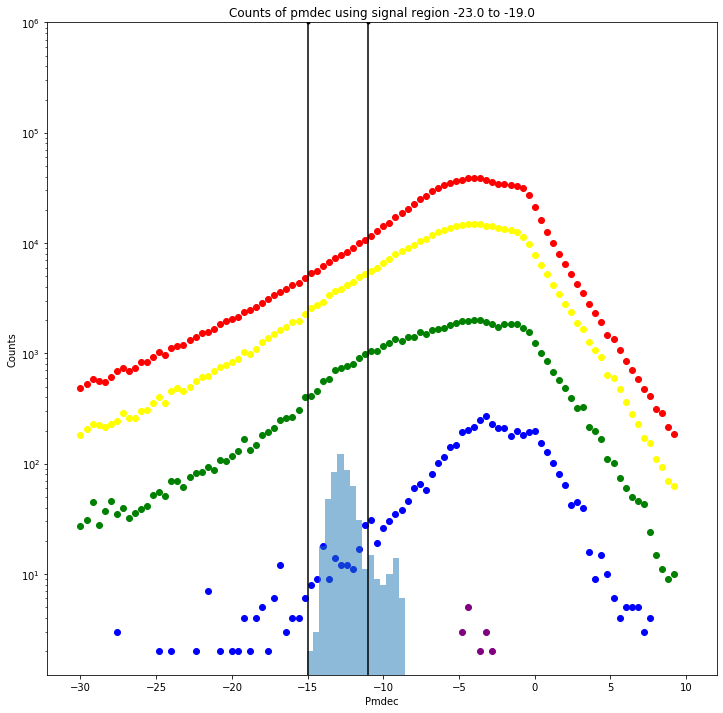

In [60]:
SR = gaiadata2[(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,0] > -11)*(gaiadata2[:,0] < -9.5)]
colors = ['red', 'yellow', 'green', 'blue', 'purple']


if len(SR) >= threshold_arr_size:
    SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
    _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
    _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
    plt.legend(frameon=False)
    plt.show()
    build_model_diff_arch(SR, SB, GD1, 1, gaiadata2, True)
    
    X_pass_stream, bins_cuts = build_model_diff_arch(SR, SB, GD1, 1, gaiadata2, True)
    plt.figure(figsize = (12, 12))
    plt.hist(X_pass_stream[:,0], alpha = 0.5, label = "GD1", bins = np.linspace(-30, 10, 100))
    for i in range(len(bins_cuts)):
        curr_color = colors[i]
        for j in range(len(bins_cuts[0])):
            plt.scatter(index_to_xcoord(j), bins_cuts[i][j], color = curr_color)
    plt.yscale('log')
    plt.ylim([0, 10e5])
    plt.xlabel('Pmdec')
    plt.ylabel('Counts')
    plt.plot([-15, -15], [0, 10e5], marker = '.', color = 'black')
    plt.plot([-11, -11], [0, 10e5], marker = '.', color = 'black')
    title_str = 'Counts of pmdec using signal region ' + str(round(pointers[1])) + ' to ' + str(round(pointers[2]))
    plt.title(title_str)
    plt.show()   

In [61]:
'hi'

'hi'

In [ ]:
# from jack's notebook
perms = list(range(len(gaiadata2[0])))
perms[0] = 0
perms[1] = 1

SR = gaiadata2[:,perms][(gaiadata2[:,0] > -15)*(gaiadata2[:,0] < -11)]
SB = gaiadata2[:,perms][(gaiadata2[:,0] > -18)*(gaiadata2[:,0] < -15)+(gaiadata2[:,perms[0]] > -11)*(gaiadata2[:,0] < -9.5)]
rest_data = gaiadata2[:,perms][np.logical_or((gaiadata2[:,0] > -9.5),(gaiadata2[:,0] < -18))]

GD1 = gaiadata3[:,perms]

theta=0

X = SR[:,3]-center_ra
Y = SR[:,2]-center_dec
Xr = X*np.cos(theta) + Y*np.sin(theta)
Yr = -X*np.sin(theta) + Y*np.cos(theta)

Xb = SB[:,3]-center_ra
Yb = SB[:,2]-center_dec
Xbr = Xb*np.cos(theta) + Yb*np.sin(theta)
Ybr = -Xb*np.sin(theta) + Yb*np.cos(theta)

Xrd = rest_data[:,3]-center_ra
Yrd = rest_data[:,2]-center_dec
Xrdr = Xrd*np.cos(theta) + Yrd*np.sin(theta)
Yrdr = -Xrd*np.sin(theta) + Yrd*np.cos(theta)

Xs = GD1[:,3]-center_ra
Ys = GD1[:,2]-center_dec
Xsr = Xs*np.cos(theta) + Ys*np.sin(theta)
Ysr = -Xs*np.sin(theta) + Ys*np.cos(theta)

SR = np.c_[SR[:,0],SR[:,1],Yr,Xr,SR[:,4],SR[:,5]]
SB = np.c_[SB[:,0],SB[:,1],Ybr,Xbr,SB[:,4],SB[:,5]]
GD1 = np.c_[GD1[:,0],GD1[:,1],Ysr,Xsr,GD1[:,4],GD1[:,5]]
rest_data = np.c_[rest_data[:,0],rest_data[:,1],Yrdr,Xrdr,rest_data[:,4],rest_data[:,5]]

X = np.concatenate([SR,SB,GD1])
Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(GD1))])
X_scaled = X
myscaler = preprocessing.StandardScaler()
myscaler.fit(X[:,1:])
X_scaled[:,1:] = myscaler.transform(X[:,1:])
GD1_scaled = X_scaled[Y==2]
X_scaled = X_scaled[Y<2]
Y = Y[Y<2]
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)


model = Sequential()
model.add(Dense(256, input_dim=5, activation='relu',bias_initializer='glorot_normal')) 
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train[:,1:],Y_train, epochs=30, batch_size=200,validation_data=(X_test[:,1:],Y_test))

preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
preds_GD1 = model.predict(GD1_scaled[:,1:6], batch_size=int(0.1*len(GD1_scaled)))

rest_data_half = np.copy(rest_data[:int(len(rest_data)/2)])
rest_data_half[:,1:] = myscaler.transform(rest_data_half[:,1:]) 
preds_rest_data = model.predict(rest_data_half[:,1:])


bins=np.linspace(-30,10,40)
#X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
X_pass_GD1 = GD1_scaled[preds_GD1[:,0] > 0]
plt.figure(figsize=(6,6))
plt.hist(X_pass_GD1[:,0],label="GD1",alpha=0.5,bins=bins,color='C1')


for cut in [0.,0.5,0.9,0.99,0.999]:

    X_pass = X_test[(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
    X_pass_rest = rest_data_half[preds_rest_data[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
    plot_all = np.concatenate((X_pass_rest,X_pass),axis=0)




    plt.hist(plot_all[:,0],alpha=1.,bins=bins,histtype='step',color='C0')

    #plt.hist(X_pass_rest[:,0],label="rest",alpha=0.5,bins=bins)
plt.yscale("log")
plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
plt.ylim([1,1e6])
plt.ylabel("Counts",fontsize=20)
plt.xlabel(r"pmdec",fontsize=20)
plt.axvline(-15,color='black')
plt.axvline(-11,color='black')
plt.text(-14,10**5,'SR',fontsize=18)
plt.show()


Train on 71263 samples, validate on 71264 samples
Epoch 1/30
71263/71263 [==============================] - 10s 134us/step - loss: 0.6940 - acc: 0.5016 - val_loss: 0.6936 - val_acc: 0.5039
Epoch 2/30
71263/71263 [==============================] - 3s 48us/step - loss: 0.6933 - acc: 0.5069 - val_loss: 0.6931 - val_acc: 0.5058
Epoch 3/30
71263/71263 [==============================] - 3s 48us/step - loss: 0.6930 - acc: 0.5100 - val_loss: 0.6932 - val_acc: 0.5070
Epoch 4/30
71263/71263 [==============================] - 3s 46us/step - loss: 0.6928 - acc: 0.5131 - val_loss: 0.6934 - val_acc: 0.5076
Epoch 5/30
71263/71263 [==============================] - 3s 46us/step - loss: 0.6926 - acc: 0.5141 - val_loss: 0.6930 - val_acc: 0.5118
Epoch 6/30
71263/71263 [==============================] - 3s 46us/step - loss: 0.6926 - acc: 0.5173 - val_loss: 0.6931 - val_acc: 0.5098
Epoch 7/30
71263/71263 [==============================] - 3s 46us/step - loss: 0.6923 - acc: 0.5170 - val_loss: 0.6928 - val_a

No handles with labels found to put in legend.


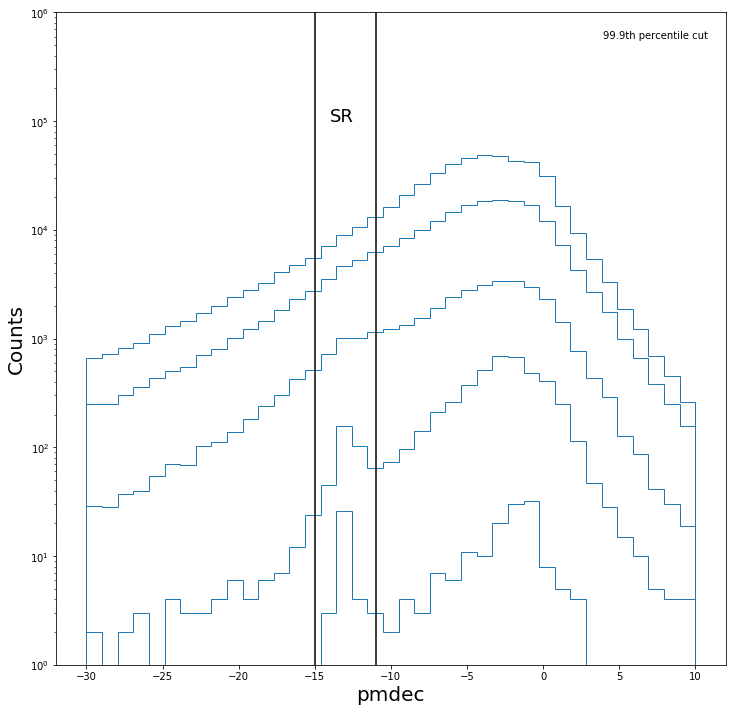

In [51]:
plt.figure(figsize = (12, 12))
for cut in [0.,0.5,0.9,0.99,0.999]:

    X_pass = X_test[(preds[:,0] > np.quantile(preds[Y_test==1],[cut])[0])]
    X_pass_rest = rest_data_half[preds_rest_data[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
    plot_all = np.concatenate((X_pass_rest,X_pass),axis=0)




    plt.hist(plot_all[:,0],alpha=1.,bins=bins,histtype='step',color='C0')

    #plt.hist(X_pass_rest[:,0],label="rest",alpha=0.5,bins=bins)
plt.yscale("log")
plt.legend(frameon=False,title=str(100*cut)+"th percentile cut",fontsize=20)
plt.ylim([1,1e6])
plt.ylabel("Counts",fontsize=20)
plt.xlabel(r"pmdec",fontsize=20)
plt.axvline(-15,color='black')
plt.axvline(-11,color='black')
plt.text(-14,10**5,'SR',fontsize=18)
plt.show()



In [ ]:
start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
# auc_arr = np.array([])
# region_mids = np.array([])
# threshold_arr_size = 10000
while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2)

    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
        _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
        _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
        plt.legend(frameon=False)
        plt.show()
        build_model(SR, SB, GD1, 1, gaiadata2, True)
        print(pointers)
#         for x, y in zip(tpr_gd1_1, fpr_gd1_1):
#             plt.plot(x, x/y**0.5)
#             plt.show()
#         auc_arr = np.append(auc_arr, auc(fpr_gd1_2[0], tpr_gd1_2[0]))
#         region_mids = np.append(region_mids, (pointers[1] + pointers[2])/2)
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

In [ ]:
start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
end_point = max(gaiadata2[:,0])
auc_arr = np.array([])
region_mids = np.array([])
threshold_arr_size = 10000
while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2_no_gd1)

    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
#         _,_,_=plt.hist(SR[:,0],bins=np.linspace(-30,10,100),label="SR")
#         _,_,_=plt.hist(SB[:,0],bins=np.linspace(-30,10,100),label="SB")
#         plt.legend(frameon=False)
#         plt.show()
        tpr_gd1_1, fpr_gd1_1, chi_arr = build_model(SR, SB, GD1, 1, True)
        print((pointers[1] + pointers[2])/2, chi_arr)
#         for x, y in zip(tpr_gd1_1, fpr_gd1_1):
#             plt.plot(x, x/y**0.5)
#             plt.show()
#         auc_arr = np.append(auc_arr, auc(fpr_gd1_2[0], tpr_gd1_2[0]))
#         region_mids = np.append(region_mids, (pointers[1] + pointers[2])/2)
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff

In [ ]:
#look at regions with 10k stars

In [ ]:
#run one model, 20 epochs for each iteration

In [ ]:
#compute auc for tpr, fpr as metric
#auc as a function of region - should be 0.5 if no stream

In [ ]:
#average of second and third numbers as region center

In [ ]:
#run with and without GD1

In [41]:
def build_model(SR, SB, stream, num_models, all_data, plot_cuts = False):
    X = np.concatenate([SR,SB,stream])
    Y = np.concatenate([np.ones(len(SR)),np.zeros(len(SB)),2.*np.ones(len(stream))])

    X = X[:, :6]
    print(X)
    X_scaled = X
    myscaler= preprocessing.StandardScaler().fit(X[:,1:])
#     myscaler= preprocessing.StandardScaler()
#     myscaler.fit(X[:,1:6])
    X_scaled[:,1:] = myscaler.transform(X[:,1:])
    
    all_data = all_data[:, :6]
    all_data_scaled = all_data
    all_data_scaled[:, 1:] = myscaler.transform(all_data[:, 1:])


    stream_scaled = X_scaled[Y==2]
    X_scaled = X_scaled[Y<2]
    Y = Y[Y<2]

    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.5)



    for i in range(num_models):

        model = Sequential()
        model.add(Dense(64, input_dim=5, activation='relu')) 
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train[:,1:],Y_train, epochs=20, batch_size=200,validation_data=(X_test[:,1:],Y_test), verbose = 0) 

        preds = model.predict(X_test[:,1:], batch_size=int(0.1*len(X_test)))
#         preds_SR = preds[(Y_test == 1) * (X_test[:, 6] == 0)]
        
        preds_all = model.predict(all_data_scaled[:, 1:], batch_size = int(0.1*len(all_data_scaled))) #0.01

        preds_stream = model.predict(stream_scaled[:,1:], batch_size=int(0.1*len(stream_scaled)))

#         X_unscaled = np.c_[myscalar.inverse_transform(X_scaled[:, :6]), X_scaled[:, 6]]

#         stream_unscaled = np.c_[myscalar.inverse_transform(stream_scaled[:, :6]), stream_scaled[:, 6]]
                
#         all_data_unscaled = np.c_[myscalar.inverse_transform(all_data_scaled[:, :6]), all_data_scaled[:, 6]]
    
#         preds = model.predict(X_test[:,1:6], batch_size=int(0.1*len(X_test)))
#         preds_GD1 = model.predict(stream_scaled[:,1:6], batch_size=int(0.1*len(stream_scaled)))

#         plt.hist(preds[Y_test==1],alpha=0.5,bins=np.linspace(0,1,20),label="SR",density=True)
#         plt.hist(preds[Y_test==0],alpha=0.5,bins=np.linspace(0,1,20),label="SB",density=True)
#         plt.legend(frameon=False)
#         plt.yscale("log")
#         plt.xlabel("NN")
#         plt.show()
#         break
    
        cuts = [0.,0.5,0.9,0.99, 0.999]
        bins_cuts = np.zeros((len(cuts), 99))
        stream_to_plot = []
        bins=np.linspace(-30,10,40)
        if plot_cuts:
            plt.figure(figsize = (12, 12))
            for j in range(len(cuts)):
                cut = cuts[j]
                print(cut)
                
                if j == 0:
                    stream_to_plot = stream_scaled[preds_stream[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
                    plt.hist(stream_to_plot[:,0], alpha = 0.5, label = "GD1", bins = bins)
#             
                X_pass_all = all_data_scaled[preds_all[:,0] > np.quantile(preds[Y_test==1],[cut])[0]]
                print(preds_all[:,0])
                print(np.quantile(preds[Y_test==1],[cut])[0])
#                 bins_cuts[j], _, _ = plt.hist(X_pass_all[:,0], bins = np.linspace(-30, 10, 100))
                plt.hist(X_pass_all[:,0], histtype='step',bins = bins)

            plt.yscale('log')
            plt.xlabel('Pmdec')
            plt.ylabel('Counts')

            return stream_to_plot, bins_cuts

[[-2.2045910e+01  4.2832798e-01 -1.1062191e+02 -1.5279031e+01
   1.5233386e-01 -7.2614767e-02]
 [-2.1357176e+01  1.3702431e+00 -1.1062191e+02 -1.5279031e+01
  -4.5265803e-01 -7.2614767e-02]
 [-2.2763691e+01  1.1401277e+00 -1.1062191e+02 -1.5279031e+01
   1.1223613e+00 -7.2614767e-02]
 ...
 [-1.0157487e+01 -3.2076640e+00  9.8219910e+00  8.7727394e+00
   2.5928307e-01  2.0548786e+01]
 [-1.3379130e+01 -4.1154761e+00  9.6493530e-01 -3.7192955e+00
   6.0620499e-01  1.8776518e+01]
 [-1.4069811e+01 -4.6100144e+00  5.5931091e+00  2.6280098e+00
   1.0135670e+00  2.0145870e+01]]
0.0
[0.7764926  0.7764113  0.78814447 ... 0.78138757 0.7845472  0.77509624]
0.452067106962204
0.5
[0.7764926  0.7764113  0.78814447 ... 0.78138757 0.7845472  0.77509624]
0.4858134090900421
0.9
[0.7764926  0.7764113  0.78814447 ... 0.78138757 0.7845472  0.77509624]
0.5333196520805359
0.99
[0.7764926  0.7764113  0.78814447 ... 0.78138757 0.7845472  0.77509624]
0.5670942902565003
0.999
[0.7764926  0.7764113  0.78814447 ... 

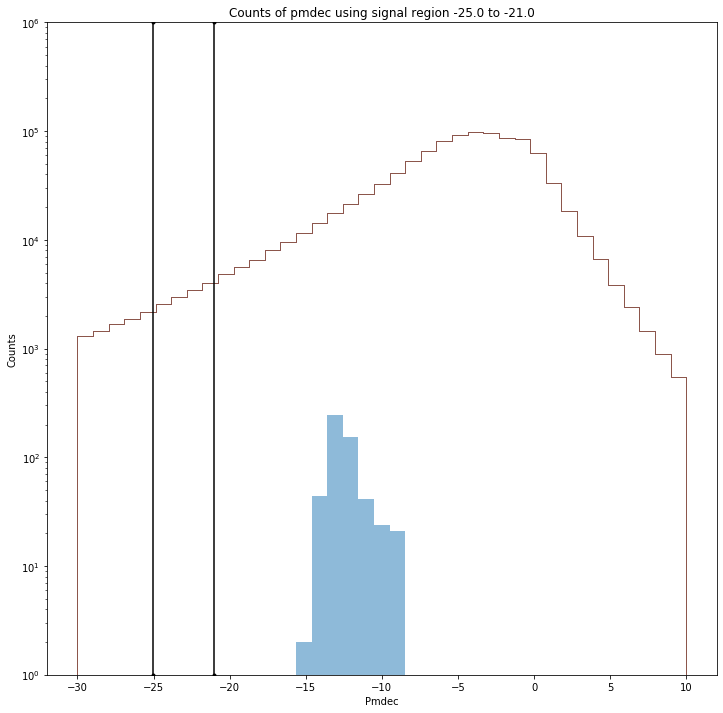

[[-2.2045910e+01  3.5724965e-01 -1.1985921e+02 -2.2438871e+01
   1.8266605e-02 -1.4553246e-01]
 [-2.1357176e+01  1.0069814e+00 -1.1985921e+02 -2.2438871e+01
  -5.8730161e-01 -1.4553246e-01]
 [-1.9553696e+01 -8.8361132e-01 -1.1985921e+02 -2.2438871e+01
  -7.6291049e-01 -1.4553246e-01]
 ...
 [-1.0157487e+01 -3.2076640e+00  9.8219910e+00  8.7727394e+00
   2.5928307e-01  2.0548786e+01]
 [-1.3379130e+01 -4.1154761e+00  9.6493530e-01 -3.7192955e+00
   6.0620499e-01  1.8776518e+01]
 [-1.4069811e+01 -4.6100144e+00  5.5931091e+00  2.6280098e+00
   1.0135670e+00  2.0145870e+01]]
0.0
[0.4390452  0.39010403 0.4012908  ... 0.40534788 0.43416366 0.38316458]
0.43794044852256775
0.5
[0.4390452  0.39010403 0.4012908  ... 0.40534788 0.43416366 0.38316458]
0.48533859848976135
0.9
[0.4390452  0.39010403 0.4012908  ... 0.40534788 0.43416366 0.38316458]
0.521027660369873
0.99
[0.4390452  0.39010403 0.4012908  ... 0.40534788 0.43416366 0.38316458]
0.5535284328460693
0.999
[0.4390452  0.39010403 0.4012908  ..

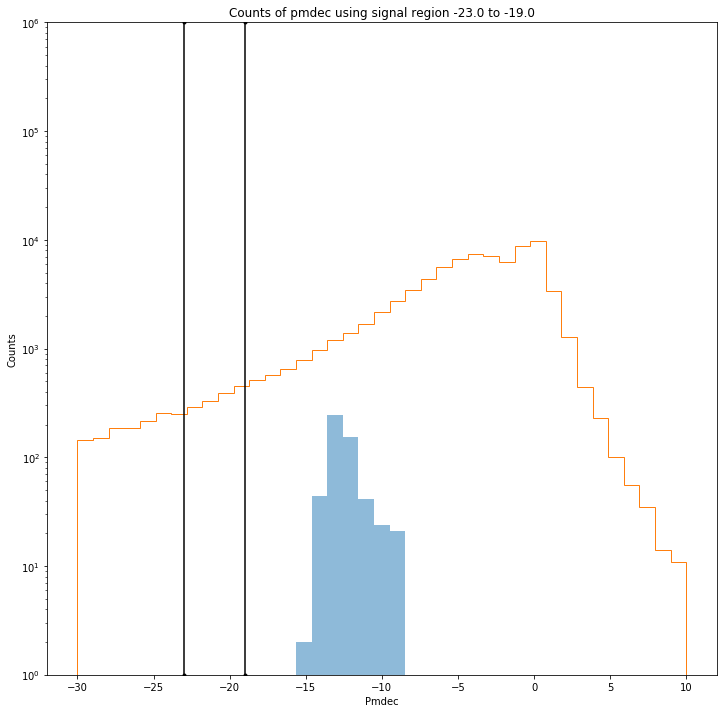

[[-1.82143497e+01  3.93591411e-02 -1.24471725e+02 -2.16972790e+01
  -9.13376808e-01 -1.24466568e-01]
 [-1.95536957e+01 -8.63559604e-01 -1.24471725e+02 -2.16972790e+01
  -7.43145049e-01 -1.24466568e-01]
 [-1.82338886e+01 -2.62021303e-01 -1.24471725e+02 -2.16972790e+01
   6.26262128e-01 -1.24466568e-01]
 ...
 [-1.01574869e+01 -3.20766401e+00  9.82199097e+00  8.77273941e+00
   2.59283066e-01  2.05487862e+01]
 [-1.33791304e+01 -4.11547613e+00  9.64935303e-01 -3.71929550e+00
   6.06204987e-01  1.87765179e+01]
 [-1.40698109e+01 -4.61001444e+00  5.59310913e+00  2.62800980e+00
   1.01356697e+00  2.01458702e+01]]
0.0
[0.88708    0.9021041  0.89458495 ... 0.89634013 0.88664055 0.9040932 ]
0.4064200520515442
0.5
[0.88708    0.9021041  0.89458495 ... 0.89634013 0.88664055 0.9040932 ]
0.46245187520980835
0.9
[0.88708    0.9021041  0.89458495 ... 0.89634013 0.88664055 0.9040932 ]
0.5082599461078644
0.99
[0.88708    0.9021041  0.89458495 ... 0.89634013 0.88664055 0.9040932 ]
0.5397296744585037
0.999


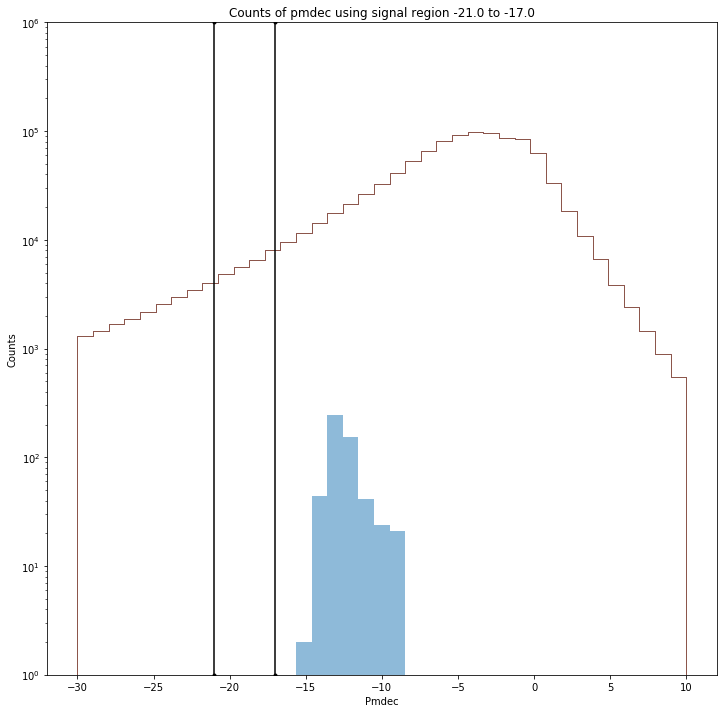

[[-1.8214350e+01  2.3559934e-02 -1.2344154e+02 -2.0129417e+01
  -8.8088679e-01 -1.0515151e-01]
 [-1.6069838e+01 -1.3464451e-01 -1.2344154e+02 -2.0129417e+01
  -4.6521068e-01 -1.0515151e-01]
 [-1.6201733e+01  4.5762366e-01 -1.2344154e+02 -2.0129417e+01
  -1.4129089e+00 -1.0515151e-01]
 ...
 [-1.0157487e+01 -3.2076640e+00  9.8219910e+00  8.7727394e+00
   2.5928307e-01  2.0548786e+01]
 [-1.3379130e+01 -4.1154761e+00  9.6493530e-01 -3.7192955e+00
   6.0620499e-01  1.8776518e+01]
 [-1.4069811e+01 -4.6100144e+00  5.5931091e+00  2.6280098e+00
   1.0135670e+00  2.0145870e+01]]
0.0
[0.6583451  0.6479257  0.6180565  ... 0.6401211  0.64231825 0.6490294 ]
0.4202214777469635
0.5
[0.6583451  0.6479257  0.6180565  ... 0.6401211  0.64231825 0.6490294 ]
0.4739741086959839
0.9
[0.6583451  0.6479257  0.6180565  ... 0.6401211  0.64231825 0.6490294 ]
0.5222934305667877
0.99
[0.6583451  0.6479257  0.6180565  ... 0.6401211  0.64231825 0.6490294 ]
0.5818029540777206
0.999
[0.6583451  0.6479257  0.6180565  ...

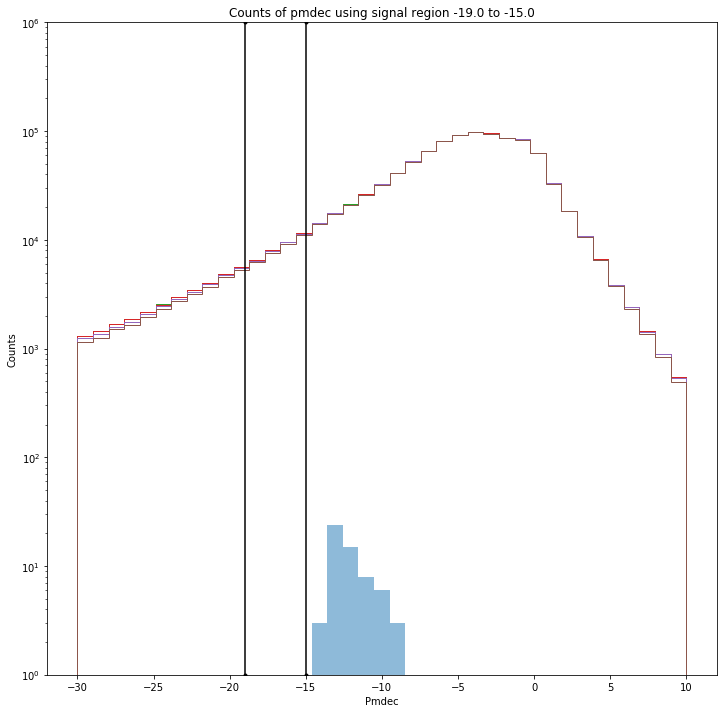

[[-1.60698376e+01 -1.88186944e-01 -1.19007835e+02 -1.80316658e+01
  -4.27546650e-01 -8.77751037e-02]
 [-1.62017326e+01  4.91695464e-01 -1.19007835e+02 -1.80316658e+01
  -1.37515152e+00 -8.77751037e-02]
 [-1.42709064e+01  1.16548991e+00 -1.19007835e+02 -1.80316658e+01
  -9.86877978e-01 -8.77751037e-02]
 ...
 [-1.01574869e+01 -3.20766401e+00  9.82199097e+00  8.77273941e+00
   2.59283066e-01  2.05487862e+01]
 [-1.33791304e+01 -4.11547613e+00  9.64935303e-01 -3.71929550e+00
   6.06204987e-01  1.87765179e+01]
 [-1.40698109e+01 -4.61001444e+00  5.59310913e+00  2.62800980e+00
   1.01356697e+00  2.01458702e+01]]
0.0
[0.9912446  0.99110293 0.9913038  ... 0.99117416 0.99129254 0.9910868 ]
0.4251613914966583
0.5
[0.9912446  0.99110293 0.9913038  ... 0.99117416 0.99129254 0.9910868 ]
0.4867687225341797
0.9
[0.9912446  0.99110293 0.9913038  ... 0.99117416 0.99129254 0.9910868 ]
0.5121411681175232
0.99
[0.9912446  0.99110293 0.9913038  ... 0.99117416 0.99129254 0.9910868 ]
0.5344491505622865
0.999
[

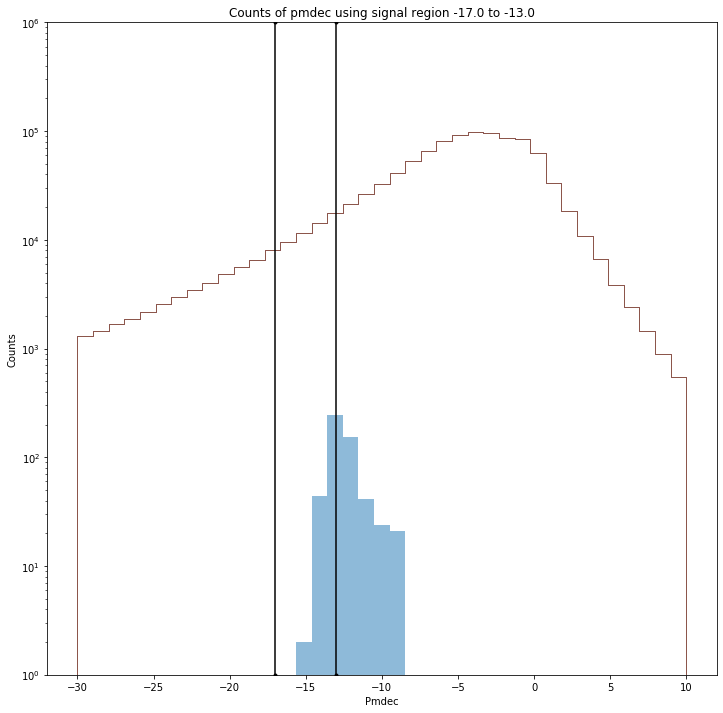

[[-1.10479984e+01  8.50836575e-01 -1.10050026e+02 -1.52725506e+01
  -1.02445841e+00 -7.26147667e-02]
 [-1.23846779e+01 -9.64491665e-01 -1.10050026e+02 -1.52725506e+01
   5.32575190e-01 -7.26147667e-02]
 [-1.42709064e+01  1.30202591e+00 -1.10050026e+02 -1.52725506e+01
  -9.43469644e-01 -7.26147667e-02]
 ...
 [-1.01574869e+01 -3.20766401e+00  9.82199097e+00  8.77273941e+00
   2.59283066e-01  2.05487862e+01]
 [-1.33791304e+01 -4.11547613e+00  9.64935303e-01 -3.71929550e+00
   6.06204987e-01  1.87765179e+01]
 [-1.40698109e+01 -4.61001444e+00  5.59310913e+00  2.62800980e+00
   1.01356697e+00  2.01458702e+01]]
0.0
[0.9937261  0.9939103  0.9936376  ... 0.99378127 0.99364144 0.9939418 ]
0.37325721979141235
0.5
[0.9937261  0.9939103  0.9936376  ... 0.99378127 0.99364144 0.9939418 ]
0.4773845374584198
0.9
[0.9937261  0.9939103  0.9936376  ... 0.99378127 0.99364144 0.9939418 ]
0.5153274774551392
0.99
[0.9937261  0.9939103  0.9936376  ... 0.99378127 0.99364144 0.9939418 ]
0.5441460800170899
0.999


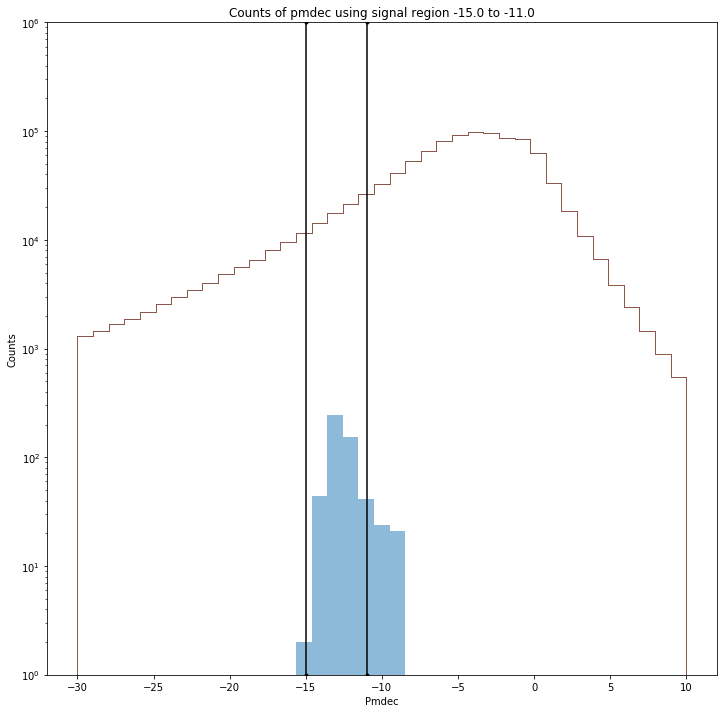

[[-9.7370386e+00  2.6124829e-01 -9.0642685e+01 -1.1535299e+01
   4.0572670e-01 -5.9527520e-02]
 [-1.0714464e+01 -6.6944563e-01 -9.0642685e+01 -1.1535299e+01
   1.3698024e+00 -5.9527520e-02]
 [-9.7807493e+00 -5.0547802e-01 -9.0642685e+01 -1.1535299e+01
   6.0550743e-01 -5.9527520e-02]
 ...
 [-1.0157487e+01 -3.2076640e+00  9.8219910e+00  8.7727394e+00
   2.5928307e-01  2.0548786e+01]
 [-1.3379130e+01 -4.1154761e+00  9.6493530e-01 -3.7192955e+00
   6.0620499e-01  1.8776518e+01]
 [-1.4069811e+01 -4.6100144e+00  5.5931091e+00  2.6280098e+00
   1.0135670e+00  2.0145870e+01]]
0.0
[0.9986828  0.9988299  0.99852943 ... 0.998711   0.9985587  0.99885464]
0.3621382713317871
0.5
[0.9986828  0.9988299  0.99852943 ... 0.998711   0.9985587  0.99885464]
0.5323845148086548
0.9
[0.9986828  0.9988299  0.99852943 ... 0.998711   0.9985587  0.99885464]
0.5666357815265657
0.99
[0.9986828  0.9988299  0.99852943 ... 0.998711   0.9985587  0.99885464]
0.6028340083360672
0.999
[0.9986828  0.9988299  0.99852943 ...

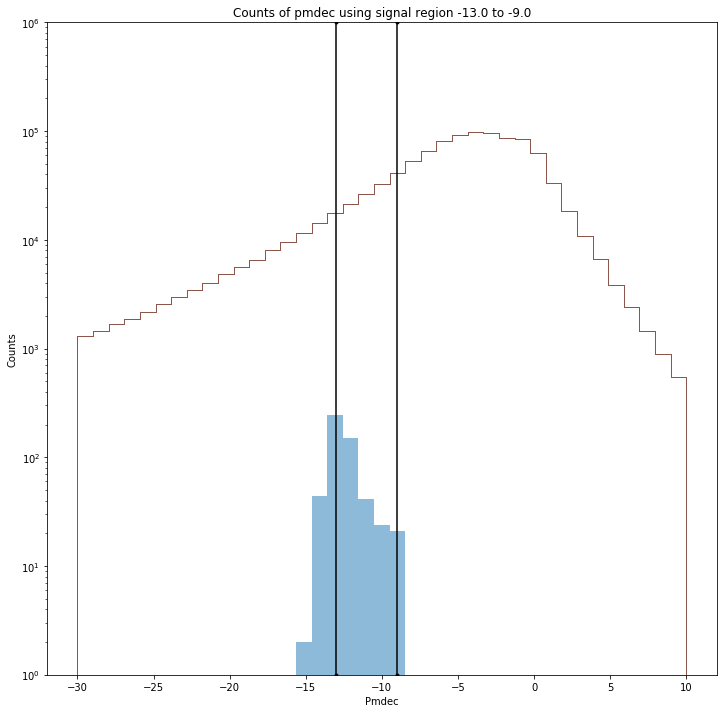

[[ -8.507724     0.6630541  -41.766785    -7.4410534   -1.232897
   -0.05138767]
 [ -7.874984    -1.3220556  -41.766785    -7.4410534   -0.28367764
   -0.05138767]
 [ -8.0306425    0.52925307 -41.766785    -7.4410534    1.3842999
   -0.05138767]
 ...
 [-10.157487    -3.207664     9.821991     8.772739     0.25928307
   20.548786  ]
 [-13.37913     -4.115476     0.9649353   -3.7192955    0.606205
   18.776518  ]
 [-14.069811    -4.6100144    5.593109     2.6280098    1.013567
   20.14587   ]]
0.0
[1. 1. 1. ... 1. 1. 1.]
0.26808324456214905
0.5
[1. 1. 1. ... 1. 1. 1.]
0.4642031788825989
0.9
[1. 1. 1. ... 1. 1. 1.]
0.5279643654823304
0.99
[1. 1. 1. ... 1. 1. 1.]
0.5760897147655487
0.999
[1. 1. 1. ... 1. 1. 1.]
0.6066981194019319


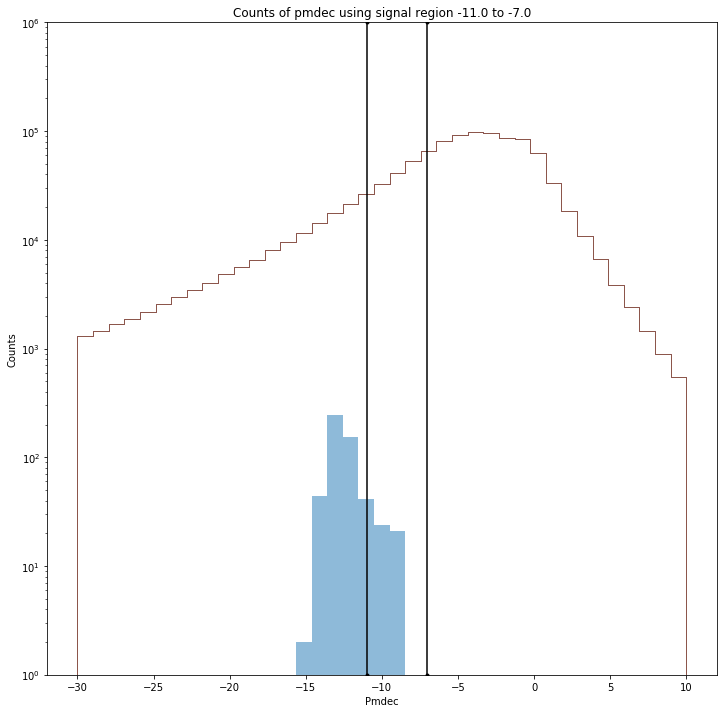

In [42]:
start_point = min(gaiadata2[:,0])
pointers = np.zeros(4)
signal_size = 4
signal_increment = 2
sb_start_diff = 0.5
pointers[0] = start_point
pointers[1] = start_point + sb_start_diff
pointers[2] = pointers[1] + signal_size
pointers[3] = pointers[2] + sb_start_diff
colors = ['red', 'yellow', 'green', 'blue', 'purple']

#where the turnaround occurs
end_point = -5

while pointers[3] <= end_point:
    SR, SB = find_SR_SB_pointers(pointers, sb_start_diff, gaiadata2)
    if len(SR) >= threshold_arr_size:
        SR, SB, GD1 = build_data_arrays(SR, SB, gaiadata3)
        X_pass_stream, bins_cuts = build_model(SR, SB, GD1, 1, gaiadata2, True)
#         plt.figure(figsize = (12, 12))
#         plt.hist(X_pass_stream[:,0], alpha = 0.5, label = "GD1", bins = np.linspace(-30, 10, 100))
#         for i in range(len(bins_cuts)):
#             curr_color = colors[i]
#             print(bins_cuts[i])
#             for j in range(len(bins_cuts[0])):
#                 plt.scatter(index_to_xcoord(j), bins_cuts[i][j], color = curr_color)
#         plt.yscale('log')
#         plt.xlabel('Pmdec')
#         plt.ylabel('Counts')
        plt.ylim([1, 1e6])
        plt.plot([pointers[1], pointers[1]], [1, 10e5], marker = '.', color = 'black')
        plt.plot([pointers[2], pointers[2]], [1, 10e5], marker = '.', color = 'black')
        title_str = 'Counts of pmdec using signal region ' + str(round(pointers[1])) + ' to ' + str(round(pointers[2]))
        plt.title(title_str)
        plt.show()   
    pointers[1] += signal_increment
    pointers[2] += signal_increment
    pointers[0] = pointers[1] - sb_start_diff
    pointers[3] = pointers[2] + sb_start_diff